In [1]:
# import library
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()
import numpy as np
from scipy.special import logsumexp
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

In [2]:
# starter code
def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_mnist(N_data=None):
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    K_data = 10
    train_labels = one_hot(train_labels, K_data)
    test_labels = one_hot(test_labels, K_data)
    if N_data is not None:
        train_images = train_images[:N_data, :]
        train_labels = train_labels[:N_data, :]

    return train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    return cax


def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)

In [3]:
def log_softmax(images, weights, w0=None):
    """ Used in Q1 and Q2
        Inputs: images, and weights
        Returns the log_softmax values."""
    if w0 is None: w0 = np.zeros(weights.shape[1])

    # YOU NEED TO WRITE THIS PART
    # transfer Y into log softmax function
    predictions = np.dot(images, weights)  # (w^T)X
    exp_sum_predictions = logsumexp(predictions, axis=1, keepdims=True)  # ln(sum(exp((w^T)X)))
    log_Y = predictions - exp_sum_predictions  # (w^T)X - ln(sum(exp((w^T)X)))

    return log_Y

In [4]:
def predict(log_Y):
    """ Used in Q1 and Q2
        Inputs: matrix of log softmax values
        Returns the predictions"""

    # YOU NEED TO WRITE THIS PART
    # Label the largest probability in each row as 1, the rest are 0s
    # keep the number in float32
    # The results would be like [[0,1,0,0,0,0,0,0,0,0],......]
    prediction = (log_Y == np.max(log_Y, axis=1, keepdims=True)).astype(np.float32)
    
        
    return prediction

In [5]:
def accuracy(log_Y, labels):
    """ Used in Q1 and Q2
        Inputs: matrix of log softmax values and 1-of-K labels
        Returns the accuracy based on predictions from log likelihood values"""
    
    # YOU NEED TO WRITE THIS PART
    prediction_new = predict(log_Y)
    
    # prediction_new would be like [[0,1,0,0,0,0,0,0,0,0],......]
    # prediction_new == 1 would create TRUE OR FALSE
    # labels would be like [[0,1,0,0,0,0,0,0,0,0],......]
    # labels == 1 would create TRUE OR FALSE as well
    # if at any one of position of prediction_new and labels both are True, then return 1, else we will get 0
    # In this example above, we have a one
    accuracy = ((prediction_new == 1) & (labels == 1)).any(axis=1).astype(np.float32)
    
    return accuracy

In [23]:
def train_gda(images, labels):
    """ Used in Q2
        Inputs: train_images, train_labels
        Returns the trained weights, the intercept, and D x K class means, 
        and D x D common covariance matrix."""
    N_data, D_data = images.shape
    K_data = labels.shape[1]

    
    # YOU NEED TO WRITE THIS PART
    # Add dimensions to matrices in order to do matrix multiplications
    t_nk = np.expand_dims(labels, axis=2)  # N*C*1 dimension
    x_n = np.expand_dims(images, axis=1)  # N*1*D dimension
    numerator =  np.sum(x_n * t_nk, axis=0) # without np.sum, dimension N*C*D; (T^T)X dimension C*D
    denominator = np.sum(t_nk, axis=0) # T dimension C*D
    miu = numerator / denominator  # (T^T)X/T

    
    x = np.expand_dims(images, axis=2)  # N*D*1 dimension
    miu_k = np.expand_dims(miu, axis=2)  # C*D*1 dimension
    
    # initialization
    sigma = []
    for k in range(K_data):
        # X - Miu
        minus = x - miu_k[k:(k+1)]  # dimension N*D*1 (X-miu)
        sigma_k = np.matmul(minus, np.transpose(minus, [0, 2, 1]))  # matrix multiplication ((X-miu)^T)(X-miu)
        # N*D*1 x N*1*D  = N*D*D 
        numerator_new = np.sum(labels[:, k:k+1, np.newaxis] * sigma_k, axis=0) # summation
        # np.newaxis increase one dimension
        denominator_new = np.sum(labels[:, k:k+1]) # N_k
        sigma_k = numerator_new / denominator_new
        sigma.append(sigma_k)  # dimension D*D
        
    sigma = np.stack(sigma, axis=0)  # dimension C*D*D
    
    # percentage of samples in each class
    percentage = np.expand_dims(np.mean(labels, axis=0), axis=[1, 2]) # dimension C*1*1; N_k/N
    Sigma = np.sum(percentage * sigma, axis=0)

    # calculation of weights
    # np.eye returns a 2-D array with ones on the diagonal and zeros elsewhere.
    # add epsilon I to make sigma invertible in case
    weights = np.dot(np.linalg.pinv(Sigma + 1. / 5000 * np.eye(D_data)), miu.T) # (sigma^-1)(miu)
    
    # calculation of w0
    prior = np.mean(labels, axis=0)  # T_nk / N; N_k/N
    w0 = - 0.5 * np.diagonal(np.dot(miu, weights)) + np.log(prior) # -(1/2)*(miu^T)(sigma^-1)(miu) + log(p(C_k))
    
    return weights, w0, miu, Sigma

(b) Plot the means of each class as an image.
The 10 images are ploted below. N_data = 5000

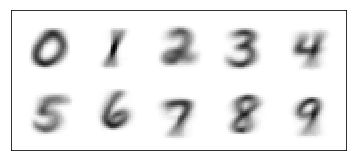

In [25]:

    N_data = 5000 # Num of samples to be used in training
    # Set this to a small number while experimenting.
    # For log reg, finally use the entire training dataset for training (N_data=None).
    # For gda, use as many training samples as your computer can handle.
    
    train_images, train_labels, test_images, test_labels = load_mnist(N_data)

    # Q2: train gaussian discriminant
    weights, w0, Mu, Sigma = train_gda(train_images, train_labels)
    save_images(Mu, 'means.png')


(c) Report the obatined accuracy in each dataset. Report the number of training images used to compute the MLE estimators.

The training accuracy is 89.1%.
The test accuracy is 78.1%.
The training error is 10.9%.
The test error is 21.9%.
The number of samples used in training is 5000.

(d) Briefly compare the performance of this model to that of logistic regression

The performance of this model is a little bit worse than that of logistic regression.
The training accuracy for the generative model is smaller than the discriminative model. (0.891 < 0.894)
The test accuracy for for the generative model is even less than the discriminative model. (0.781 < 0.881)
Notice that the number of samples used to obtain the results is different for these two models. Also notice that the images generated by the means are clearer than the images generated by the weights.

The training accuracy is  0.891
The training error is  0.109
The test accuracy is  0.781
The test error is  0.219


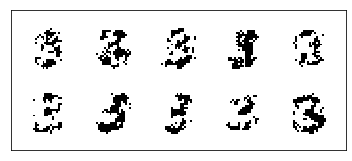

In [37]:
    new_digit = 3
    new_images = np.random.multivariate_normal(Mu.T[:, new_digit], Sigma, 10)
    save_images((new_images > .5).astype(float), 'new_images.png')
    
    # evaluation
    log_softmax_train = log_softmax(train_images, weights, w0)
    log_softmax_test = log_softmax(test_images, weights, w0)
    
    train_accuracy = accuracy(log_softmax_train, train_labels)
    training_accuracy_final = np.mean(train_accuracy)
    training_error =  1 - training_accuracy_final
    
    test_accuracy = accuracy(log_softmax_test[:5000], test_labels[:5000])
    test_accuracy_final = np.mean(test_accuracy)
    test_error =  1 - test_accuracy_final

    print("The training accuracy is ", round(training_accuracy_final,3))
    print("The training error is ", round(training_error,3))
    print("The test accuracy is ", test_accuracy_final)
    print("The test error is ", round(test_error,3))

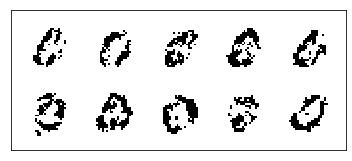

In [38]:
new_digit = 0
new_images = np.random.multivariate_normal(Mu.T[:, new_digit], Sigma, 10)
save_images((new_images > .5).astype(float), 'new_images.png')

(e) Generate 10 images from digit 0 and 10 images from digit 3

The above two images are 20 images we generated from the generative model.